In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
import torch
import os
import gym
from stable_baselines3.common.callbacks import BaseCallback

In [22]:
class GradientClippingCallback(BaseCallback):
    def __init__(self, clip_value=0.5, verbose=0):
        super(GradientClippingCallback, self).__init__(verbose)
        self.clip_value = clip_value

    def _on_step(self):
        torch.nn.utils.clip_grad_norm_(self.model.policy.parameters(), self.clip_value)
        return True

In [23]:
def evaluate_sensitivity(model, environment, feature_indices):
    original_state = environment.reset()
    print("Original state shape:", original_state.shape)
    sensitivities = []
    for idx in feature_indices:
        if idx >= original_state.shape[0]:
            print(f"Index {idx} is out of bounds for the state with shape {original_state.shape}")
            continue
        perturbed_state = np.copy(original_state)
        perturbation = 0.01 * (np.max(original_state) - np.min(original_state))
        perturbed_state[idx] += perturbation
        action, _states = model.predict(original_state, deterministic=True)
        perturbed_action, _ = model.predict(perturbed_state, deterministic=True)
        sensitivity = np.abs(action - perturbed_action)
        sensitivities.append(sensitivity)
    return sensitivities

In [47]:
class TransferEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, data):
        super(TransferEnv, self).__init__()
        self.data = data
        self.action_space = gym.spaces.Discrete(len(data['team'].unique()))
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(data.columns),))

        self.state = self.reset()

    def validate_observations(self, obs):
        if np.isnan(obs).any():
            print("NaN detected in observations")
            obs = np.nan_to_num(obs)
        return obs

    def reset(self):
        self.current_step = 0
        obs = self.data.iloc[self.current_step].values
        return self.validate_observations(obs)

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= len(self.data)
        reward = self.calculate_reward(action)
        if not done:
            next_state = self.data.iloc[self.current_step].values
        else:
            next_state = np.zeros_like(self.data.iloc[0].values)
        return self.validate_observations(next_state), reward, done, {}

    def calculate_reward(self, action):
        if self.current_step == 0:
            return 0
        else:
            previous_value = self.data.iloc[self.current_step - 1]['marketValue']
            current_value = self.data.iloc[self.current_step]['marketValue']
            reward = current_value - previous_value
            return reward

    def render(self, mode='human', close=False):
        pass

In [48]:
script_dir = os.path.abspath(os.getcwd())
print(script_dir)
project_dir = os.path.abspath(os.path.join(script_dir, os.pardir, os.pardir))
print(project_dir)

C:\Users\Klaudia\PycharmProjects\TalentFinder\ml\regresion
C:\Users\Klaudia\PycharmProjects\TalentFinder


In [49]:
def convert_season(season):
    start, end = season.split('/')

    if int(start) >= 25:
        start = '19' + start
    else:
        start = '20' + start

    if int(end) >= 25:
        end = '19' + end
    else:
        end = '20' + end


    return f"{start}/{end}"
def assign_season(date):
    if date.month < 8:
        return f"{date.year-1}/{date.year}"
    else:
        return f"{date.year}/{date.year+1}"

def generate_value_season(df_player_values):
    df_player_values['date'] = pd.to_datetime(df_player_values['date'], format='%d.%m.%Y', errors='coerce')
    df_player_values['season'] = df_player_values['date'].apply(assign_season)
    return df_player_values

def load_data():
    dtype_dict = {
        'column_3': str,
        'column_4': str,
        'column_5': str
    }
    df_player_seasons = pd.read_csv(os.path.join(project_dir, 'data', 'transfermarkt', 'player_seasons.csv'))
    df_player_values = pd.read_csv(os.path.join(project_dir, 'data', 'transfermarkt','player_value.csv'))
    df_player_flags = pd.read_csv(os.path.join(project_dir, 'data', 'flags','player_flags_FINAL.csv'), low_memory=False, dtype=dtype_dict)
    df_player_transfers = pd.read_csv(os.path.join(project_dir, 'data', 'transfermarkt','transfers.csv'),dtype={'transferType': str})
    df_player_players = pd.read_csv(os.path.join(project_dir, 'data', 'transfermarkt','players.csv'))
    return df_player_seasons, df_player_values, df_player_flags, df_player_transfers, df_player_players


In [50]:
df_player_seasons, df_player_values, df_player_flags, df_player_transfers, df_player_players = load_data()
df_player_values = generate_value_season(df_player_values)
df_player_transfers['season'] = df_player_transfers['season'].apply(convert_season)
result = pd.merge(df_player_flags, df_player_players, on='id')
result = pd.merge(result, df_player_values, on=['id','season'])
result = pd.merge(result, df_player_transfers, on=['id', 'season'])
label_encoders = {}

In [51]:
file = pd.read_csv(os.path.join(project_dir, 'ml', 'random_forest','elo_combined_updated_manual_v2.csv')).drop(columns=['elo_ranking_club']).rename(columns={"club": "team",})
manual_elo_values = {
    'Legia Warszawa': 2057.30,
    'Rakow Czestochowa': 2056.73,
    'Lech Poznan': 2028.27,
    'Jagiellonia Bialystok': 2010.47,
    'Pogon Szczecin': 1979.33,
    'Slask Wroclaw': 1936.03,
    'Piast Gliwice': 1934.58,
    'Cracovia Krakow': 1908.82,
    'Zaglebie Lubin': 1898.70,
    'Gornik Zabrze': 1891.41,
    'Korona Kielce': 1886.56,
    'Radomiak Radom': 1852.95,
    'Widzew Lodz': 1851.43,
    'Ruch Chorzow': 1829.66,
    'Warta Poznan': 1813.30,
    'Puszcza Niepolomice': 1804.84,
    'Stal Mielec': 1764.82,
    'LKS Lodz': 1729.92,
    'Arka Gdynia': 1874.70,
    'Lechia Gdansk': 1836.87,
    'Wisla Krakow': 1834.11,
    'GKS Katowice': 1785.84,
    'Wisla Plock': 1769.47,
    'Motor Lublin': 1766.02,
    'GKS Tychy': 1737.78,
    'Miedz Legnica': 1734.90,
    'LKS Nieciecza': 1722.74,
    'Gornik Leczna': 1696.46,
    'Odra Opole': 1691.37,
    'Polonia Warszawa': 1652.76,
    'Znicz Pruszkow': 1649.86,
    'Resovia Rzeszow': 1646.33,
    'Podbeskidzie Bielsko Biala': 1637.50,
    'Chrobry Glogow': 1636.25,
    'Stal Rzeszow': 1606.55,
    'Zaglebie Sosnowiec': 1572.21,
    'Pogon Siedlce': 1628.91,
    'Kotwica Kolobrzeg': 1618.69,
    'Stal Stalowa Wola': 1613.80,
    'KKS 1925 Kalisz': 1587.47,
    'Olimpia Grudziadz': 1578.32,
    'Chojniczanka Chojnice': 1573.93,
    'Hutnik Krakow': 1566.19,
    'SKRA Czestochowa': 1565.43,
    'Polonia Bytom': 1561.88,
    'Wisla Pulawy': 1548.34,
    'Olimpia Elblag': 1541.09,
    'Stomil Olsztyn': 1511.45,
    'GKS Jastrzebie': 1509.57,
    'Lech Poznan II': 1505.25,
    'Sandecja Nowy Sacz': 1501.80,
    'Lks Lodz II': 1493.72,
    'Zaglebie Lubin II': 1493.26,
    'Radunia Stezyca': 1489.67
}

In [52]:
for club, elo in manual_elo_values.items():
    file.loc[file['team'] == club, 'elo'] = elo
result= pd.merge(result, file, on=['team'])
result.to_csv('football_players_data.csv')

In [53]:
for column in [ 'season', 'team', 'RED_CARD_PLAYER', 'VALUE_FLAG', 'ZERO_EXP',
    'ALWAYS_ON_BENCH', 'PROGRESS_SINCE_NEW_TEAM',
    'SAME_RESULTS_FOR_LONG_TIME', 'YELLOW_CARD_PLAYER', 'place_of_birth', 'birth_date', 'nationality','position',
    'manager', 'club', 'fee','clubName1', 'clubName2']:
    le = LabelEncoder()
    result[column] = le.fit_transform(result[column])
    label_encoders[column] = le
result = result.sort_values(by=['id', 'season'])

In [58]:
result['previous_market_value'] = result.groupby('id')['marketValue'].shift(1)

result['previous_market_value'] = result['previous_market_value'].fillna(result['marketValue'])

target = result['marketValue']
result['height'] = result['height'].fillna(1.80)
features = result.drop(columns=['marketValue','slug', 'name', 'date_x', 'date_y','place_of_birth', 'manager','clubName1', 'clubName2','value', 'club', 'transferType'])
features2 = result.drop(columns=['slug', 'name', 'date_x', 'date_y', 'transferType'])

unique_ids = result['id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.25, random_state=42)

train_data = result[result['id'].isin(train_ids)]
test_data = result[result['id'].isin(test_ids)]


In [59]:
X_train = train_data.drop(columns=['marketValue','slug', 'name', 'date_x', 'date_y','place_of_birth', 'manager','clubName1', 'clubName2', 'value', 'club'])
y_train = train_data['marketValue']
X_test = test_data.drop(columns=['marketValue','slug', 'name', 'date_x', 'date_y','place_of_birth', 'manager','clubName1', 'clubName2', 'value', 'club'])
y_test = test_data['marketValue']

# le_club = LabelEncoder()
# result['club'] = le_club.fit_transform(result['club'])
# X_train['club'] = le_club.transform(X_train['club'])
# X_test['club'] = le_club.transform(X_test['club'])
# 
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
# 
X_train = X_train.dropna(axis=1, how='any')
X_test = X_test.dropna(axis=1, how='any')

In [60]:
from sklearn.metrics import mean_absolute_error

# data_without_id = result.drop(columns=['id', 'season'])
# data_description = data_without_id.describe()
# print("Statystyki opisowe dla zbioru danych:")
# print(data_description)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')
print(f'MAE:{mae}')

MSE: 2616270011189474.5
RMSE: 51149486.91032467
R2 Score: 0.7136351808339857
MAE:11167351.474693406


In [62]:
from stable_baselines3 import PPO
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
df_scaled = pd.DataFrame(ss.fit_transform(features2), columns=features2.columns)

data = df_scaled
env = TransferEnv(data)


model_rl = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0001)
model_rl.learn(total_timesteps=20000, callback=GradientClippingCallback(clip_value=0.5))
feature_indices = range(len(features))
sensitivities = evaluate_sensitivity(model_rl, env, feature_indices)
print("Feature sensitivities:", sensitivities)


   # env = TransferEnv(model, result, features)
    #model_rl = PPO("MlpPolicy", env, verbose=1)

obs = env.reset()
for _ in range(1000):
    action, _states = model_rl.predict(obs)
    obs, rewards, dones, info = env.step(action)
    print(f"Action taken: {action}, Reward received: {rewards}")
    if dones:
        break

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\Klaudia\PycharmProjects\pythonProject1\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 401  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 323         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016739804 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.95       |
|    explained_variance   | -0.193      |
|    learning_rate        | 0.0001      |
|    loss                 | 1.38        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0622     |
|    value_loss           | 1.88        |
-----------------------------------------
----------------------------------

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Action taken: 916, Reward received: -0.001082628624812454
Action taken: 1373, Reward received: 0.001082628624812454
Action taken: 2033, Reward received: -0.000541314312406227
Action taken: 2523, Reward received: 0.000541314312406227
Action taken: 983, Reward received: 1.6206950513442493
Action taken: 1703, Reward received: 0.0
Action taken: 2170, Reward received: -1.6163645368449995
Action taken: 1978, Reward received: -0.001082628624812454
Action taken: 2118, Reward received: 0.001082628624812454
Action taken: 230, Reward received: -0.001082628624812454
Action taken: 668, Reward received: 0.001082628624812454
Action taken: 599, Reward received: 0.0
Action taken: 914, Reward received: 1.1833130869200161
Action taken: 2573, Reward received: 0.0
Action taken: 963, Reward received: -0.10826286248124584
Action taken: 2417, Reward received: 0.0
Action taken: 2342, Reward received: -1.0745089101263643
Action taken: 2562, Reward received: 0.0
Action taken: 2740, Reward received: 0.0
Action ta

In [63]:
print(label_encoders)
club_encoder = label_encoders['team']
print(club_encoder)
inverse_club_mapping = {index: label for index, label in enumerate(club_encoder.classes_)}

for i in range(1000):
    action, _states = model_rl.predict(obs)
    action = action.item() 
    club_name = inverse_club_mapping[action]
    print(f"Action taken: {action} Proposed club: {club_name}")
    obs, rewards, dones, info = env.step(action)
    if dones:
        break

{'season': LabelEncoder(), 'team': LabelEncoder(), 'RED_CARD_PLAYER': LabelEncoder(), 'VALUE_FLAG': LabelEncoder(), 'ZERO_EXP': LabelEncoder(), 'ALWAYS_ON_BENCH': LabelEncoder(), 'PROGRESS_SINCE_NEW_TEAM': LabelEncoder(), 'SAME_RESULTS_FOR_LONG_TIME': LabelEncoder(), 'YELLOW_CARD_PLAYER': LabelEncoder(), 'place_of_birth': LabelEncoder(), 'birth_date': LabelEncoder(), 'nationality': LabelEncoder(), 'position': LabelEncoder(), 'manager': LabelEncoder(), 'club': LabelEncoder(), 'fee': LabelEncoder(), 'clubName1': LabelEncoder(), 'clubName2': LabelEncoder()}
LabelEncoder()
Action taken: 448 Proposed club: CD Mafra
Action taken: 2344 Proposed club: SV Schalding-Heining
Action taken: 1058 Proposed club: FC Viitorul Constanta U19
Action taken: 79 Proposed club: ACSO Filiasi
Action taken: 1546 Proposed club: KF Liria Prizren
Action taken: 2385 Proposed club: Sarpsborg 08 FF
Action taken: 2396 Proposed club: Sestao River
Action taken: 364 Proposed club: Beitar Tel Aviv Ramla
Action taken: 428 P

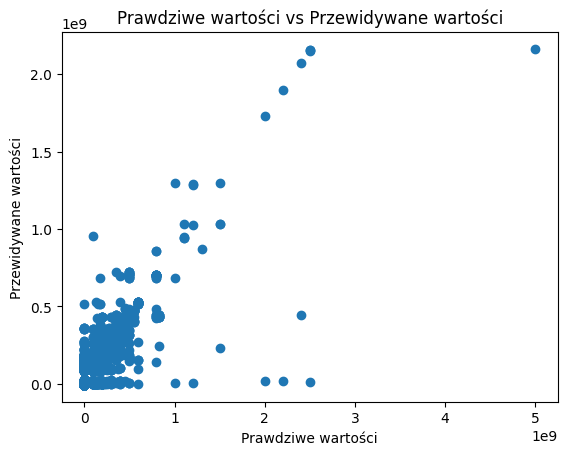

Statystyki opisowe dla residuals:
count    2.397200e+04
mean     3.328301e+05
std      5.114947e+07
min     -8.560391e+08
25%     -4.278464e+06
50%     -1.875828e+06
75%      9.564674e+04
max      2.837095e+09
Name: marketValue, dtype: float64


In [14]:
import matplotlib.pyplot as plt

plt.scatter(y_test, predictions)
plt.xlabel('Prawdziwe wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Prawdziwe wartości vs Przewidywane wartości')
plt.show()

residuals = y_test - predictions
residuals_description = residuals.describe()
print("Statystyki opisowe dla residuals:")
print(residuals_description)

In [15]:
inverse_club_mapping = {index: label for index, label in enumerate(club_encoder.classes_)}

def predict_best_club_and_market_value(player_features):
    max_value = -np.inf
    best_club_index = None
    
    for club_index in range(len(le_club.classes_)):
        player_features_with_club = np.append(player_features, club_index)
        
        predicted_value = model.predict([player_features_with_club])[0]
        
        if predicted_value > max_value:
            max_value = predicted_value
            best_club_index = club_index
            
    best_club_name = le_club.inverse_transform([best_club_index])[0]
    return best_club_name, max_value

In [16]:
player_features_example = X_test.iloc[0]
predicted_club, predicted_value = predict_best_club_and_market_value(player_features_example)
print(f"Predicted best club: {le_club.inverse_transform([predicted_club])[0]}, Predicted market value: {predicted_value}")

NameError: name 'le_club' is not defined